# Instalare snntorch

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.6 MB/s eta 0:00:00


# Import-uri necesare

In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import itertools

from IPython.display import HTML

# Variabile pentru setari

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
num_epochs = 5
learning_rate = 1e-3
time_steps = 25 # nr timesteps pentru encoding

# Dataset-ul MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # aduce pixelii in [0,1]
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Rate Encoding folosind spikegen

In [ ]:
def rate_encode(inputs, time_steps):
    return spikegen.rate(inputs, num_steps=time_steps)

# Reteaua SNN

In [ ]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.lif1 = snn.Leaky(beta=0.95)  # neuron LIF
        self.fc2 = nn.Linear(512, 10)
        self.lif2 = snn.Leaky(beta=0.95)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []  # salvare spike-uri de output

        for step in range(x.size(0)):  # pentru fiecare timestep
            curent1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(curent1, mem1)

            curent2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(curent2, mem2)

            spk2_rec.append(spk2)

        spk2_rec = torch.stack(spk2_rec)
        return spk2_rec

# Initializare model

In [ ]:
net = SNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

#Antrenare

In [ ]:
for epoch in range(num_epochs):
    net.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        images = images.view(batch_size, -1)
        images = rate_encode(images, time_steps)

        optimizer.zero_grad()
        outputs = net(images)

        out_sum = outputs.sum(0)
        loss = loss_fn(out_sum, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = out_sum.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100.*correct/total:.2f}%')


Epoch [1/5], Loss: 121.4368, Accuracy: 92.11%
Epoch [2/5], Loss: 40.1170, Accuracy: 97.39%
Epoch [3/5], Loss: 26.5143, Accuracy: 98.21%
Epoch [4/5], Loss: 22.3426, Accuracy: 98.45%
Epoch [5/5], Loss: 17.6117, Accuracy: 98.74%


# Testare

In [ ]:
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.view(batch_size, -1)
        images = rate_encode(images, time_steps)

        outputs = net(images)
        out_sum = outputs.sum(0)

        _, predicted = out_sum.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

Test Accuracy: 97.82%


# Testare pentru o singura imagine

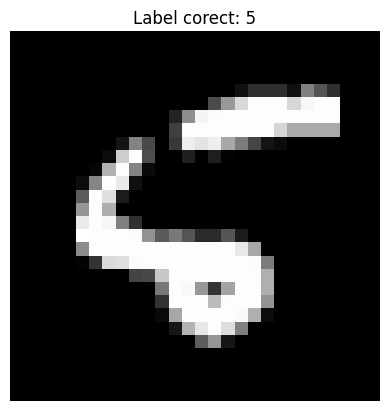

Network Prediction: 5


In [ ]:
def test_single_image(model, loader, time_steps, device, img_index=0):
    model.eval()

    images, labels = next(iter(loader))
    image = images[img_index].view(-1).unsqueeze(0).to(device)
    label = labels[img_index]

    plt.imshow(images[img_index].squeeze(), cmap="gray")
    plt.title(f"Label corect: {label.item()}")
    plt.axis('off')
    plt.show()

    spikes = spikegen.rate(image, num_steps=time_steps)

    with torch.no_grad():
        outputs = model(spikes)
        outputs_sum = outputs.sum(0)
        prediction = outputs_sum.argmax(1).item()

    print(f"Network Prediction: {prediction}")


test_single_image(net, test_loader, time_steps, device, img_index=8)


#Animare spike-ruri

In [ ]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=13889b57ecdd0ccce5f566b969b9206632071f554ff71ebc1f1cc4c8683d57bf
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [ ]:
def animate_spike_image(model, loader, time_steps, device, img_index=0):
    model.eval()

    images, labels = next(iter(loader))
    image = images[img_index].view(-1).unsqueeze(0).to(device)
    label = labels[img_index]

    spikes = spikegen.rate(image, num_steps=time_steps)

    with torch.no_grad():
        outputs = model(spikes)
        outputs_sum = outputs.sum(0)
        prediction = outputs_sum.argmax(1).item()

    spikes = spikes.squeeze(1).cpu()

    fig, ax = plt.subplots()
    img_plot = ax.imshow(spikes[0].view(28,28), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Label: {label.item()} - Prediction: {prediction}")
    plt.axis('off')

    def update(frame):
        img_plot.set_data(spikes[frame].view(28,28))
        return [img_plot]

    anim = animation.FuncAnimation(fig, update, frames=time_steps, interval=100, blit=True)

    plt.close(fig)

    return HTML(anim.to_html5_video())

animate_spike_image(net, test_loader, time_steps, device, img_index=8)
